# One layer autoencoder

Using keras module with compression to 32 floats.

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input, the dense function corresponds to our "regular" neural net, where every input
# neuron is connected to every output neuron
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Encoder Model:

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Decoder Model:

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

Binary Cross Entropy = Binomial Cross Entropy = Special Case of Multinomial Cross Entropy 

The adadelta optimizer paper is stored in the docs folder of the repo.

![Cross Entropy](images\2017-12-03 10_42_19-Machine Learning_ Should I use a categorical cross entropy or binary cross entro.png)

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

We use a validation dataset to tune hyperparameters.

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_val, _) = mnist.load_data()

Best practice is to keep some data for testing.

In [6]:
# x_test = x_val[:2000]

In [7]:
# x_val = x_val[2000:10001]

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [8]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_val.shape)
# print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs. open up tensor board with `tensorboard --logdir=/tmp/autoencoder` in command line.

In [9]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.3786 - val_loss: 0.2731
Epoch 2/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.2663 - val_loss: 0.2563
Epoch 3/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2463 - val_loss: 0.2340
Epoch 4/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2259 - val_loss: 0.2155
Epoch 5/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.2101 - val_loss: 0.2021
Epoch 6/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1985 - val_loss: 0.1920
Epoch 7/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.1895 - val_loss: 0.1842
Epoch 8/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1823 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1762 - val_loss: 0.1719
Epoch

### batchsize

Batch size defines number of samples that going to be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up batch_size equal to 100. Algorithm takes first 100 samples (from 1st to 100th) from the training dataset and trains network. Next it takes second 100 samples (from 101st to 200th) and train network again. We can keep doing this procedure until we will propagate through the networks all samples. The problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get final 50 samples and train the network.

Advantages:

* It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.
* Typically networks trains faster with mini-batches. That's because we update weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages:

* The smaller the batch the less accurate estimate of the gradient. In the figure below you can see that mini-batch (green color) gradient's direction fluctuates compare to the full batch (blue color).

![https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network](images\lU3sx.png)

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.10. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [10]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_val)
decoded_imgs = decoder.predict(encoded_imgs)

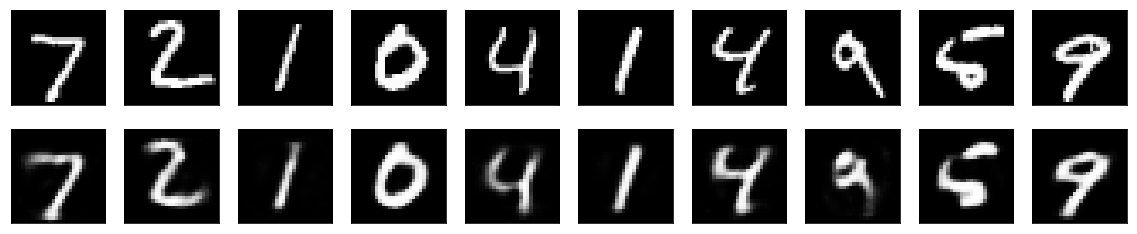

In [11]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoded respresentation
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(encoded_imgs[i].reshape(6, 6))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
encoded_imgs[0]

array([  0.698888  ,   3.25230885,   6.86422396,   4.63279915,
         7.78813744,   8.7075119 ,   0.82695365,   4.68716764,
         5.22506905,   2.78032088,  15.13985062,   3.27541447,
         3.03736138,   4.36152601,   2.39354134,   5.88554764,
        10.81248474,  11.3058548 ,  13.16264343,   3.72177529,
         4.88094759,   3.82862711,   9.59315014,   4.4199419 ,
         4.74569845,   4.34726954,   6.88422298,   2.40307426,
         7.83422613,   0.88472939,   4.40892124,   1.4649471 ], dtype=float32)

# Stacked Autoencoder

In [13]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [14]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.3413 - val_loss: 0.2616
Epoch 2/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2543 - val_loss: 0.2443
Epoch 3/100
60000/60000 [==============================] - 7s 112us/step - loss: 0.2339 - val_loss: 0.2185
Epoch 4/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.2119 - val_loss: 0.2060
Epoch 5/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.2022 - val_loss: 0.1962
Epoch 6/100
60000/60000 [==============================] - 6s 99us/step - loss: 0.1923 - val_loss: 0.1854
Epoch 7/100
60000/60000 [==============================] - 6s 99us/step - loss: 0.1818 - val_loss: 0.1761
Epoch 8/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1747 - val_loss: 0.1723
Epoch 9/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1685 - val_loss

60000/60000 [==============================] - 6s 97us/step - loss: 0.1051 - val_loss: 0.1035
Epoch 77/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1048 - val_loss: 0.1039
Epoch 78/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.1045 - val_loss: 0.1038
Epoch 79/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1043 - val_loss: 0.1040
Epoch 80/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.1042 - val_loss: 0.1040
Epoch 81/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1040 - val_loss: 0.1036
Epoch 82/100
60000/60000 [==============================] - 6s 99us/step - loss: 0.1038 - val_loss: 0.1036
Epoch 83/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.1035 - val_loss: 0.1023
Epoch 84/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.1033 - val_loss: 0.1022
Epoch 85/100
60000/60000 [======================

In [15]:
encoded_imgs = encoder.predict(x_val)
decoded_imgs = decoder.predict(encoded_imgs)

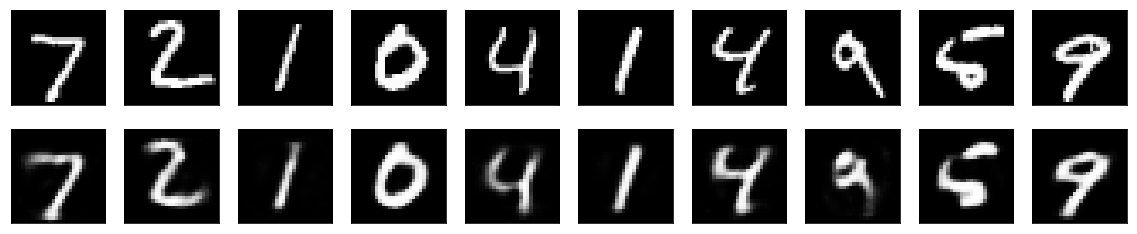

In [18]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Data

In [ ]:
(x_train, _), (x_val, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1)) 

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Stick with the stack

In [ ]:
from keras.callbacks import TensorBoard

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])